# (30) KL Balancer

**Motivation**: Debug. <br>

In [1]:
# HIDE CODE


import os, sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML
# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')
# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
from model.vae2d import VAE
from model.train_vae import TrainerVAE

from torch import _dynamo
_dynamo.config.cache_size_limit = 1024

In [3]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=5,
    scale_init=False, ada_groups=True, residual_kl=False,
))
tr = TrainerVAE(
    # model=torch.compile(vae),
    model=vae,
    cfg=ConfigTrain(
        lr=0.003, batch_size=512, epochs=1000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-5, lambda_norm=1e-2,
        kl_beta=1, kl_anneal_cycles=0),
    device='cuda',
)
vae.cfg.total_latents()

150

In [9]:
vae.enc0[1].dims

[1, 2, 3]

In [34]:
x, norm = next(iter(tr.dl_tst))
with torch.no_grad():
    y, _, q, p = tr.model(x)
    kl_all, kl_diag = tr.model.loss_kl(q, p)

In [35]:
from model.utils_model import kl_balancer as hadi

In [36]:
self = tr
alpha = self.alphas
coeff = self.betas[2000]
beta = self.cfg.kl_beta

In [37]:
balanced_kl_hadi, gamma_hadi, kl_vals_hadi = hadi(kl_all, alpha, coeff, beta)

In [38]:
gamma_hadi

tensor([0.7949, 0.8578, 0.7993, 0.6783, 0.5866, 0.6408, 0.8419, 0.3419, 0.5713,
        0.5191, 0.6939, 1.1721, 1.7183, 1.4775, 1.0333, 1.4136, 1.6136, 1.6540,
        1.4441, 1.1103, 1.4425, 1.1693, 1.1969, 0.9247, 1.0388, 0.8849, 0.8082,
        0.7917, 0.9472, 0.8333], device='cuda:0')

In [39]:
balanced_kl_hadi

tensor([0.1990, 0.2648, 0.4416, 0.2776, 0.4627, 0.2846, 0.1957, 0.2428, 0.1864,
        0.1925, 0.1986, 0.8973, 0.2601, 0.2069, 0.4113, 0.1822, 1.6090, 0.9014,
        0.3611, 0.2737, 0.1965, 0.1871, 0.2331, 0.3501, 0.3134, 0.3046, 0.2201,
        0.1857, 0.2382, 0.1794, 0.2019, 0.1893, 0.3603, 0.1953, 0.1790, 0.3835,
        0.5815, 0.9122, 0.1849, 0.3253, 0.1980, 0.2025, 0.1888, 0.2350, 0.4466,
        0.2364, 0.2145, 0.2585, 0.2864, 0.1869, 0.8017, 0.2065, 0.3460, 0.2556,
        0.3376, 0.2189, 0.2826, 0.2428, 0.2954, 0.2021, 0.8540, 1.0958, 0.3085,
        0.2120, 0.1817, 0.2101, 0.2121, 0.1836, 0.2190, 0.2970, 3.4314, 0.1942,
        0.2336, 0.9997, 0.1992, 0.8648, 0.2131, 0.3037, 0.6240, 0.1823, 0.2194,
        0.3115, 0.2063, 0.3918, 0.6348, 0.2084, 0.2037, 0.2058, 0.4219, 0.2654,
        0.6904, 0.2010, 0.2110, 0.2823, 0.2717, 0.3475, 0.1924, 0.1922, 0.3340,
        0.2115, 0.2900, 0.2528, 0.1825, 0.2220, 0.2004, 0.1868, 0.4263, 0.2916,
        0.2148, 0.2290, 0.1751, 0.2890, 

In [72]:
kl_balancer_coeff_arash(vae.cfg.n_latent_scales, vae.cfg.groups, 'sqrt')

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142,
        1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142,
        1.4142, 1.4142, 1.4142], device='cuda:0')

In [68]:
def kl_balancer_coeff_arash(num_scales, groups_per_scale, fun):
    if fun == 'equal':
        coeff = torch.cat([torch.ones(groups_per_scale[num_scales - i - 1]) for i in range(num_scales)], dim=0).cuda()
    elif fun == 'linear':
        coeff = torch.cat([(2 ** i) * torch.ones(groups_per_scale[num_scales - i - 1]) for i in range(num_scales)], dim=0).cuda()
    elif fun == 'sqrt':
        coeff = torch.cat([np.sqrt(2 ** i) * torch.ones(groups_per_scale[num_scales - i - 1]) for i in range(num_scales)], dim=0).cuda()
    elif fun == 'square':
        coeff = torch.cat([np.square(2 ** i) / groups_per_scale[num_scales - i - 1] * torch.ones(groups_per_scale[num_scales - i - 1]) for i in range(num_scales)], dim=0).cuda()
    else:
        raise NotImplementedError
    # convert min to 1.
    coeff /= torch.min(coeff)
    return coeff



def kl_per_group(kl_all):
    kl_vals = torch.mean(kl_all, dim=0)
    kl_coeff_i = torch.abs(kl_all)
    kl_coeff_i = torch.mean(kl_coeff_i, dim=0, keepdim=True) + 0.01

    return kl_coeff_i, kl_vals


def kl_balancer_arash(kl_all, kl_coeff=1.0, kl_balance=False, alpha_i=None):
    if kl_balance and kl_coeff < 1.0:
        alpha_i = alpha_i.unsqueeze(0)

        kl_all = torch.stack(kl_all, dim=1)
        kl_coeff_i, kl_vals = kl_per_group(kl_all)

        kl_coeff_i = kl_coeff_i / alpha_i
        kl_coeff_i = kl_coeff_i / torch.mean(kl_coeff_i, dim=1, keepdim=True)
        kl = torch.sum(kl_all * kl_coeff_i.detach(), dim=1)

        # for reporting
        kl_coeffs = kl_coeff_i.squeeze(0)
    else:
        kl_all = torch.stack(kl_all, dim=1)
        kl_vals = torch.mean(kl_all, dim=0)
        kl = torch.sum(kl_all, dim=1)
        kl_coeffs = torch.ones(size=(len(kl_vals),))

    return kl_coeff * kl, kl_coeffs, kl_vals

In [61]:
balanced_kl_arash, kl_coeffs_arash, kl_vals_arash = kl_balancer_arash(
    kl_all, coeff, kl_balance=True, alpha_i=alpha)

In [62]:
kl_coeffs_arash

tensor([0.8101, 0.8684, 0.8142, 0.7022, 0.6173, 0.6675, 0.8537, 0.3908, 0.6031,
        0.5548, 0.7166, 1.1593, 1.6649, 1.4420, 1.0308, 1.3829, 1.5680, 1.6054,
        1.4111, 1.1021, 1.4096, 1.1568, 1.1822, 0.9303, 1.0359, 0.8934, 0.8225,
        0.8071, 0.9511, 0.8456], device='cuda:0')

In [63]:
gamma_hadi

tensor([0.7949, 0.8578, 0.7993, 0.6783, 0.5866, 0.6408, 0.8419, 0.3419, 0.5713,
        0.5191, 0.6939, 1.1721, 1.7183, 1.4775, 1.0333, 1.4136, 1.6136, 1.6540,
        1.4441, 1.1103, 1.4425, 1.1693, 1.1969, 0.9247, 1.0388, 0.8849, 0.8082,
        0.7917, 0.9472, 0.8333], device='cuda:0')

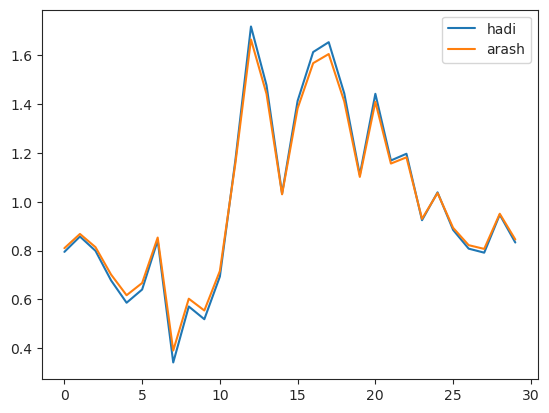

In [64]:
plt.plot(to_np(gamma_hadi), label='hadi')
plt.plot(to_np(kl_coeffs_arash), label='arash')
plt.legend()

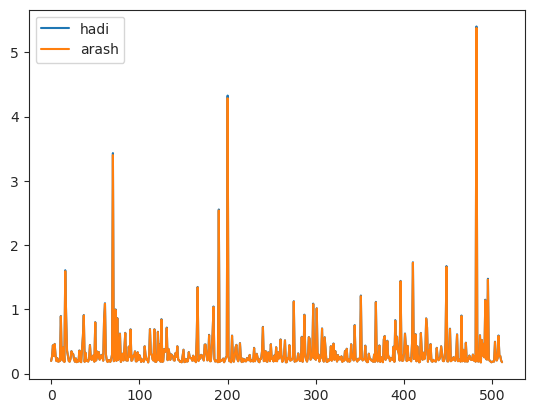

In [65]:
plt.plot(to_np(balanced_kl_hadi), label='hadi')
plt.plot(to_np(balanced_kl_arash), label='arash')
plt.legend()

In [66]:
sp_stats.pearsonr(to_np(balanced_kl_hadi), to_np(balanced_kl_arash))

(0.999996266721964, 0.0)

In [24]:
kl_all = torch.stack(kl_all, dim=1)
kl_vals = torch.mean(kl_all, dim=0)
kl_all.size(), kl_vals.size()

(torch.Size([512, 30]), torch.Size([30]))

In [25]:
kl_coeff_i = torch.mean(
    torch.abs(kl_all),
    keepdim=True,
    dim=0,
) + 0.01
kl_coeff_i.size()

torch.Size([1, 30])

In [29]:
kl_coeff_i.squeeze()[2].item()

0.1095895990729332

In [30]:
len(kl_diag)

30

0.02491855062544346

In [ ]:
alpha = alpha.unsqueeze(0)

In [37]:
## kl_per_group()
kl_vals = torch.mean(kl_all, dim=0)
kl_coeff_i = torch.mean(
    torch.abs(kl_all),
    keepdim=True,
    dim=0,
) + 0.01

kl_vals.size(), kl_coeff_i.size()

(torch.Size([30]), torch.Size([1, 30]))

In [44]:
kl_coeff_i

tensor([[0.1090, 0.1168, 0.1096, 0.0945, 0.0831, 0.0898, 0.1148, 0.0526, 0.0811,
         0.0746, 0.0964, 0.1559, 0.2239, 0.1937, 0.1386, 0.1860, 0.2108, 0.2158,
         0.1898, 0.1482, 0.1896, 0.1556, 0.1591, 0.1251, 0.1394, 0.1201, 0.1106,
         0.1086, 0.1280, 0.1138]], device='cuda:0')

In [45]:
total_kl = torch.sum(kl_coeff_i)
total_kl

tensor(4.0346, device='cuda:0')

In [46]:
kl_coeff_i = kl_coeff_i / alpha * total_kl
kl_coeff_i

tensor([[0.4396, 0.4712, 0.4420, 0.3811, 0.3351, 0.3621, 0.4633, 0.2120, 0.3273,
         0.3011, 0.3889, 0.6289, 0.9034, 0.7815, 0.5592, 0.7505, 0.8504, 0.8706,
         0.7659, 0.5980, 0.7651, 0.6277, 0.6418, 0.5047, 0.5623, 0.4847, 0.4463,
         0.4380, 0.5163, 0.4590]], device='cuda:0')

In [47]:
kl_coeff_i = kl_coeff_i / torch.mean(
    kl_coeff_i, dim=1, keepdim=True)
kl_coeff_i

tensor([[0.8102, 0.8684, 0.8146, 0.7024, 0.6176, 0.6674, 0.8539, 0.3908, 0.6032,
         0.5549, 0.7167, 1.1591, 1.6649, 1.4404, 1.0307, 1.3831, 1.5673, 1.6044,
         1.4114, 1.1021, 1.4101, 1.1568, 1.1827, 0.9302, 1.0363, 0.8932, 0.8226,
         0.8072, 0.9516, 0.8459]], device='cuda:0')

In [50]:
kl = torch.sum(kl_all * kl_coeff_i.detach(), dim=1)
kl_coeffs = kl_coeff_i.squeeze(0)

In [51]:
kl_coeffs

tensor([0.8102, 0.8684, 0.8146, 0.7024, 0.6176, 0.6674, 0.8539, 0.3908, 0.6032,
        0.5549, 0.7167, 1.1591, 1.6649, 1.4404, 1.0307, 1.3831, 1.5673, 1.6044,
        1.4114, 1.1021, 1.4101, 1.1568, 1.1827, 0.9302, 1.0363, 0.8932, 0.8226,
        0.8072, 0.9516, 0.8459], device='cuda:0')